# Data Preparation
This notebook details the data preparation steps for Comper.

## 1. Grab the dataset
1. Go to [https://salu133445.github.io/musegan/dataset](https://salu133445.github.io/musegan/dataset)
2. Download the `lpd-5-cleansed.tgz` dataset.
3. Extract it into a folder `lpd-5-cleansed`.
4. You should see three layers of subfolders labelled 'A'-'J', and then leaf folders named something like `TRJJFLV128F92FC46E/`, each containing a file which looks something like `c28d6d22cf7298890c5cc5f21ac2244d.npz` (this is a numpy zip file, more information [here](https://salu133445.github.io/pypianoroll/save_load.html))

## 2. Flatten all files into one folder

1. `cd` to the root of your dataset.
2. Check that there are 24474 .npz files using 
```bash
find . -mindepth 2 -type f | wc -l
```
3. Move all files to the current directory for easier access later: 
```bash
find . -mindepth 2 -type f -print -exec mv --backup=numbered {} . \;
``` 
([What?](https://askubuntu.com/questions/146634/shell-script-to-move-all-files-from-subfolders-to-parent-folder))
4. Rename all "~#~" extensions to "~#.npz" so that numpy doesn't reject the file later on.
```bash
rename 's/\~$/\.npz/' *~
```
4. Remove the empty folders `rm -r */` (Don't forget the slash!)
5. Confirm that you have the correct number of files using `ls | wc -l`.


## 3. Grab a random subset of files to play with
We'll use 100 files to start. 

In [25]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt

LPD5_DIR = "/media/junshern/s_drive/FYP/MIDI/lpd_5_cleansed_copy"
DATA_DIR = "./pianorolls"
NUM_FILES = 100


In [26]:

# Create a new directory for our pianorolls
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)
    # Grab a random subset of files from our LPD5 dataset to play with
    files_subset = random.sample(os.listdir(LPD5_DIR), NUM_FILES) # Sampling without replacement
    for filename in files_subset:
        src = os.path.join(LPD5_DIR, filename)
        dest = os.path.join(DATA_DIR, filename)
        shutil.copyfile(src, dest)
    print "Copied", NUM_FILES, "files to", DATA_DIR, "."
else:
    print "Directory already exists."

# Print the first 10 files of our chosen subset
print(os.listdir(DEST_DIR)[:10])

Copied 100 files to ./pianorolls .
['825743bc60816514d61574b44abc4d22.npz', '035d2131e824eb51878007013786806a.npz', 'c7523bfd41d67de23b7e1d7575284821.npz', 'bc11aedb9c44074c732f6aac7ac9a3a3.npz.~4.npz', 'ee98ebdda35b94d0d6ba19c194db9911.npz', 'e9bfc85ab76f224f686b8a142570ab6e.npz', 'd1002f0b1b1e687baa750467113e219c.npz', '1fc99c6776860dbec8fe64dd4cc52e73.npz', '9e1d04631b8ad65addff1a9f755132aa.npz.~1.npz', 'c016f976fb71e75d8fcd931e08f64ae6.npz.~1.npz']


## 4. Inspect the data

From the MuseGAN page:

> In LPD-5, the tracks of each multi-track piano-rolls are merged into five common categories: bass, drums, piano, guitar and strings according to the program numbers provided in the MIDI files. Note that instruments out of the list are considered as part of the strings

We use [pypianoroll](https://github.com/salu133445/pypianoroll), created by the authors of MuseGAN to manipulate the data. The pypianoroll library gives us a ton of helpful methods which makes it easy to find out more about each file. (pypianoroll [docs](https://salu133445.github.io/pypianoroll/index.html))

In [29]:

def printInfo(track):
    print "\n#####################"
    print "Name: ", track.name
    print "isDrum: ", track.is_drum
    print "Program: ", track.program
    if len(track.pianoroll):
        print "Active length: ", track.get_active_length()
        print "Active pitch range: ", track.get_active_pitch_range()
    else:
        print "Empty pianoroll."
    print ""

# Pick a file to look at
filename = random.choice(os.listdir(DATA_DIR))
print(filename)
# Load pianoroll file as a multitrack object
multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
# Show some info about the pianoroll
for track in multi.tracks:
    printInfo(track)


bf385f3d5fe91e20bbe42194757e7ef1.npz

#####################
Name:  Guitar
isDrum:  False
Program:  24
Empty pianoroll.


#####################
Name:  Piano
isDrum:  False
Program:  0
Active length:  5808
Active pitch range:  (50, 73)


#####################
Name:  Bass
isDrum:  False
Program:  32
Active length:  7340
Active pitch range:  (20, 37)


#####################
Name:  Drums
isDrum:  True
Program:  0
Active length:  7945
Active pitch range:  (28, 72)


#####################
Name:  Strings
isDrum:  False
Program:  48
Active length:  7952
Active pitch range:  (40, 78)



## 5. Extract pianorolls from the Piano track of all files

(22912, 128)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[36 36 36 ... 36 36 36]
 [36 36 36 ... 36 36 36]
 [36 36 36 ... 36 36 36]
 ...
 [36 36 36 ... 36 36 36]
 [36 36 36 ... 36 36 36]
 [36 36 36 ... 36 36 36]]
(22912, 128)


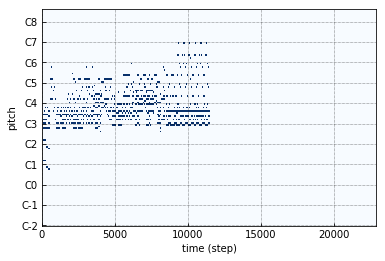

In [48]:
# pianorolls = [] # List to hold all our piano rolls
filename = random.choice(os.listdir(DATA_DIR))
# Load pianoroll file as a multitrack object
multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
for track in multi.tracks:
    # Non-empty piano pianoroll
    if track.name == "Piano" and len(track.pianoroll):
        track.pianoroll = track.pianoroll.clip()
        print(track.pianoroll.shape)
        print(track.pianoroll[:,:10])
        print(track.pianoroll.clip(36,96)[:,:10])
        print(track.pianoroll.shape)
        fig, ax = track.plot()
        plt.show()